# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Задача

Подготовить модель, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды.

# Описание данных

**Технологический процесс**
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
1. Xanthate — ксантогенат (промотер, или активатор флотации);
2. Sulphate — сульфат (на данном производстве сульфид натрия);
2. Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

**Параметры этапов**
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

import scipy.stats as stats

# Подготовка данных

## Осмотр данных

Согласно описанию две из трех данных таблиц являются лишь частями третьей таблицы `gold_recovery_full_new.csv`. Причем если `gold_recovery_train_new.csv` является тренировочной выборкой из оригинальной таблицы `full`, то `gold_recovery_test_new.csv` является тестовой выборкой из которой были убранны значения некоторых столбцов. Значит для общего понимания достаточно просмотреть только одну из таблиц.

In [2]:
data_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
data_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
data_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

Количество столбцов слишком велико, чтобы их поштучно изучать. Лучше сначала понять какие из них вообще понадобятся.

Кроме того, все данные является количественными, а в некоторых столбцах присутсвуют пустые значения.

## Проверка правильности расчета эффективности обогащения

Эфективность обогащения рассчитвается согласно следующей формуле:
$$ Recovery = \frac {C*(F-T)} {F*(C-T)} * 100\% $$
где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Рассчитаем эффективность обогащения:

In [4]:
recovery_check = (
    (data_train['rougher.output.concentrate_au'] * (data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au'])) /
    (data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au'])) * 100
)

Сравним с оригинальными значениями, при округлении до 8го знака после запятой.

In [5]:
(recovery_check.round(8) == data_train['rougher.output.recovery'].round(8)).mean()

1.0

Видно, что наши рассчетные значения и значения из таблицы полностью совпадают. Следовательно проверку значения MAE между ними можно не проводить так как оно все равно ноль или очень к нему близко. 

In [6]:
recovery_check.round(8)

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

## Анализ признаков недоступных в тестовой выборке

In [7]:
difference = set(data_train.columns) - set(data_test.columns)
difference

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Из чего видно, что в тестовой выборке отсутствуют значения `output` всех этапов очистки. И все значения `calculation`, которые есть только на этапе флотации.

Следует зарание добавить значения *'rougher.output.recovery'* и *'final.output.recovery'* в тестовую таблицу.

In [8]:
data_test = data_test.join(data_full[['rougher.output.recovery', 'final.output.recovery']], how='left')

In [9]:
data_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.8659

Кроме того стоит убедиться, что в тестовых значениях нет пропусков.

In [10]:
data_test.isna().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.sulfate                  4
primary_cleaner.input.xanthate                 4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank4_a_level     0
secondary_cleaner.state.floatbank3_a_level     0
rougher.state.floatbank10_f_level              0
rougher.output.recovery                        0
secondary_cleaner.state.floatbank6_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
secondary_cleaner.state.floatbank6_a_air       0
secondary_cleaner.state.floatbank2_b_level     0
secondary_cleaner.st

Увы, они есть. Пустые значения в тестовой выборке для предсказания непригодны, так что их причется удалить.

In [11]:
data_test = data_test.dropna()

## Предобработка

### Удаление столбцов

Предположим, что в тестовую выборку заказчик вложил те параметры которые ему доступны перед запуском производства, а значит и перед совершением предсказания. Хотя параметры типа `calculation`, судя по их названиям, хоть и рассчитываются чуть позже, все же должны быть доступны с самого начала.

Значит, первым шагом будет удаление из тренировочной выборки тех столбцов, что отсутсвуют в тестовой. Кроме двух: *'final.output.recovery'* и *'rougher.output.recovery'*, поскольку именно они будут предсказываться.

In [12]:
data_train = data_train.drop(difference - {'final.output.recovery', 'rougher.output.recovery'}, axis=1)

In [13]:
data_train.shape

(14149, 54)

### Форматирование временных индексов

In [14]:
data_train.index

Index(['2016-01-15 00:00:00', '2016-01-15 01:00:00', '2016-01-15 02:00:00',
       '2016-01-15 03:00:00', '2016-01-15 04:00:00', '2016-01-15 05:00:00',
       '2016-01-15 06:00:00', '2016-01-15 07:00:00', '2016-01-15 08:00:00',
       '2016-01-15 09:00:00',
       ...
       '2018-08-18 01:59:59', '2018-08-18 02:59:59', '2018-08-18 03:59:59',
       '2018-08-18 04:59:59', '2018-08-18 05:59:59', '2018-08-18 06:59:59',
       '2018-08-18 07:59:59', '2018-08-18 08:59:59', '2018-08-18 09:59:59',
       '2018-08-18 10:59:59'],
      dtype='object', name='date', length=14149)

Если взглянуть на индексы, заметно что измерения показателей проводились каждый час. Значит все датафреймы можно привести индексы к формату Datetime с округлением до часа.

In [15]:
data_train.index = pd.to_datetime(data_train.index, format='%Y-%m-%dT%H:%M:%S').round('H')
data_test.index = pd.to_datetime(data_test.index, format='%Y-%m-%dT%H:%M:%S').round('H')
data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%dT%H:%M:%S').round('H')
data_train.index

DatetimeIndex(['2016-01-15 00:00:00', '2016-01-15 01:00:00',
               '2016-01-15 02:00:00', '2016-01-15 03:00:00',
               '2016-01-15 04:00:00', '2016-01-15 05:00:00',
               '2016-01-15 06:00:00', '2016-01-15 07:00:00',
               '2016-01-15 08:00:00', '2016-01-15 09:00:00',
               ...
               '2018-08-18 02:00:00', '2018-08-18 03:00:00',
               '2018-08-18 04:00:00', '2018-08-18 05:00:00',
               '2018-08-18 06:00:00', '2018-08-18 07:00:00',
               '2018-08-18 08:00:00', '2018-08-18 09:00:00',
               '2018-08-18 10:00:00', '2018-08-18 11:00:00'],
              dtype='datetime64[ns]', name='date', length=14149, freq=None)

### Заполение пустых значений

Посмотрим на количества пустых значений по столбцам.

In [16]:
data_train.isna().sum().sort_values(ascending=False)

rougher.state.floatbank10_e_air               436
rougher.input.floatbank11_xanthate            428
secondary_cleaner.state.floatbank2_a_air      217
rougher.input.feed_size                       144
rougher.input.feed_pb                         100
primary_cleaner.input.xanthate                100
rougher.input.feed_sol                         78
rougher.input.floatbank11_sulfate              36
primary_cleaner.input.depressant               32
rougher.input.floatbank10_sulfate              29
secondary_cleaner.state.floatbank2_b_air       21
primary_cleaner.input.sulfate                  20
rougher.input.floatbank10_xanthate              8
rougher.input.feed_rate                         8
secondary_cleaner.state.floatbank4_a_air        6
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_a_air          4
secondary_cleaner.state.floatbank3_a_air        4
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_c_air          2


Разберемся с пропусками в порядке убывания.

#### rougher.state.floatbank10_e_air

In [17]:
rougher_nans = data_train['rougher.state.floatbank10_e_air'].loc[data_train['rougher.state.floatbank10_e_air'].isna()]
rougher_nans

date
2018-01-13 07:00:00   NaN
2018-01-13 08:00:00   NaN
2018-01-13 09:00:00   NaN
2018-01-13 10:00:00   NaN
2018-01-13 11:00:00   NaN
                       ..
2018-02-23 11:00:00   NaN
2018-02-23 12:00:00   NaN
2018-02-23 13:00:00   NaN
2018-02-23 14:00:00   NaN
2018-02-23 15:00:00   NaN
Name: rougher.state.floatbank10_e_air, Length: 436, dtype: float64

Значит с 2018-01-13 07:00:00 до 2018-02-23 15:00:00 по какой-то причине показания этого датчика отсутсвуют. Посмотрим на то, насколько взаимосвязаны между собой объемы воздуха в различных флотационных резервуарах.

In [18]:
rougher_air = data_train.loc[:, data_train.columns.str.endswith('air') & data_train.columns.str.startswith('rougher')]
rougher_air.corr()

,rougher.state.floatbank10_a_air,rougher.state.floatbank10_b_air,rougher.state.floatbank10_c_air,rougher.state.floatbank10_d_air,rougher.state.floatbank10_e_air,rougher.state.floatbank10_f_air
rougher.state.floatbank10_a_air,1.000000,-0.241865,-0.319040,-0.350769,-0.167054,-0.136809
rougher.state.floatbank10_b_air,-0.241865,1.000000,0.937161,0.928081,0.830794,0.823817
rougher.state.floatbank10_c_air,-0.319040,0.937161,1.000000,0.913406,0.779243,0.757487
rougher.state.floatbank10_d_air,-0.350769,0.928081,0.913406,1.000000,0.884600,0.859770
rougher.state.floatbank10_e_air,-0.167054,0.830794,0.779243,0.884600,1.000000,0.940696
rougher.state.floatbank10_f_air,-0.136809,0.823817,0.757487,0.859770,0.940696,1.000000


Корреляция между объемами воздуха проходящими чере резервуары b, c, d, e и f довольно высоки. Взгянем на графическое отображение объемов воздуха в резервуарах в период когда показания с резервуара e отсутсвуют.

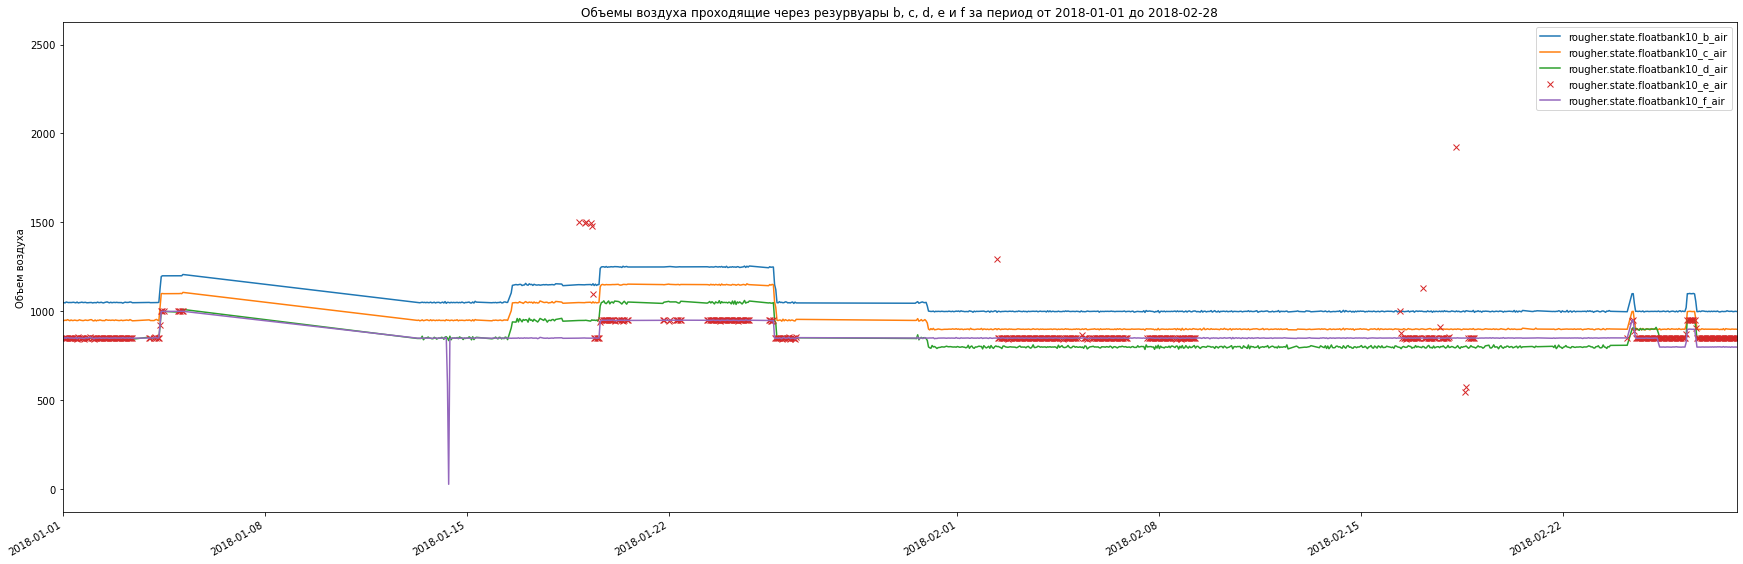

In [19]:
rougher_air.drop('rougher.state.floatbank10_a_air', axis=1).plot.line(style={'rougher.state.floatbank10_e_air': 'x'}, xlim=('2018-01-01 00:00:00', '2018-02-28 0:00:00'), figsize=(30, 10))
plt.title('Объемы воздуха проходящие через резурвуары b, c, d, e и f за период от 2018-01-01 до 2018-02-28')
plt.xlabel('')
plt.ylabel('Объем воздуха')
plt.show()

По графику заметно, что в тех участках, где есть показания с резурвуара e, показания очень схожи с показаниями с резервуара f. А значит пропуски в показаниях с резервуара e можно заменить показаниями с резервуара f.

In [20]:
data_train['rougher.state.floatbank10_e_air'] = data_train['rougher.state.floatbank10_e_air'].fillna(data_train['rougher.state.floatbank10_f_air'])

Проверим эффективность заполнения:

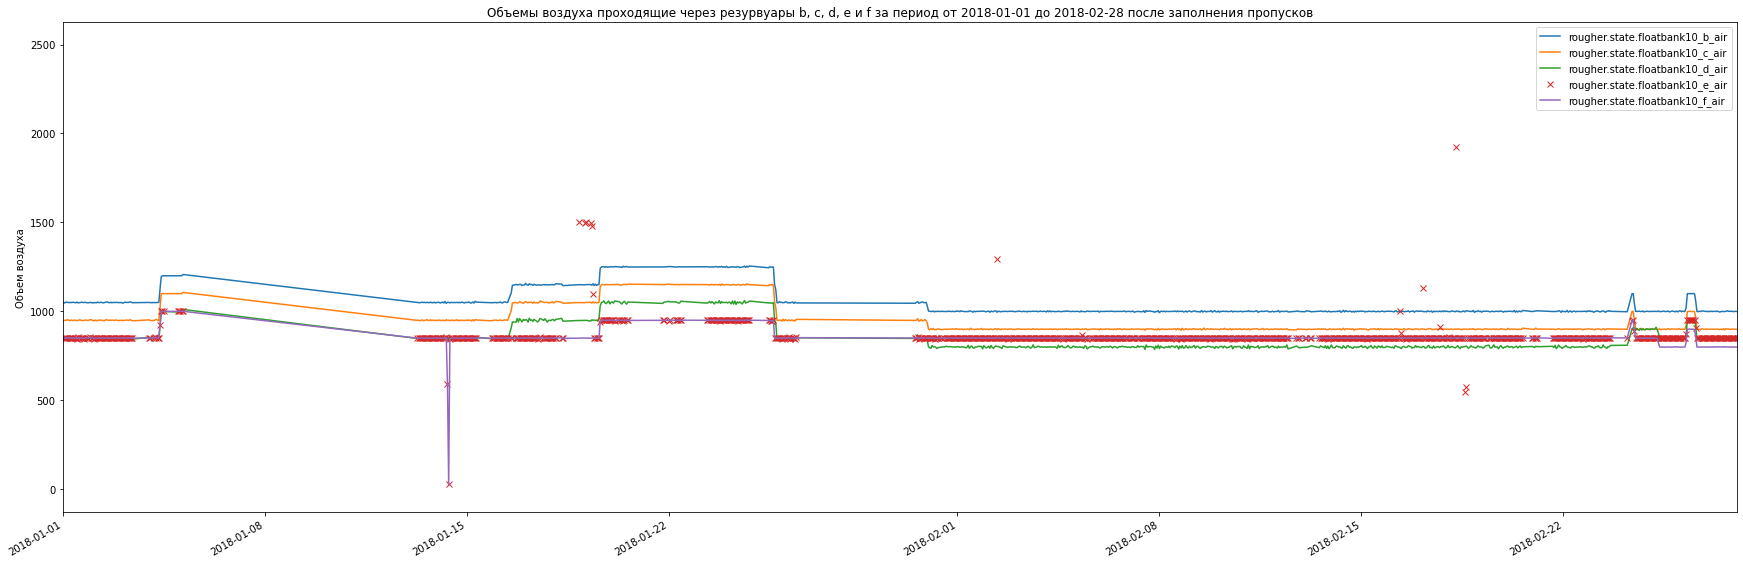

In [21]:
rougher_air = data_train.loc[:, data_train.columns.str.endswith('air') & data_train.columns.str.startswith('rougher')]
rougher_air.drop('rougher.state.floatbank10_a_air', axis=1).plot.line(style={'rougher.state.floatbank10_e_air': 'x'}, xlim=('2018-01-01 00:00:00', '2018-02-28 0:00:00'), figsize=(30, 10))
plt.title('Объемы воздуха проходящие через резурвуары b, c, d, e и f за период от 2018-01-01 до 2018-02-28 после заполнения пропусков')
plt.xlabel('')
plt.ylabel('Объем воздуха')
plt.show()

#### rougher.input.floatbank11_xanthate

In [22]:
rougher_nans = data_train['rougher.input.floatbank11_xanthate'].loc[data_train['rougher.input.floatbank11_xanthate'].isna()]
rougher_nans.head(10)

date
2016-01-19 02:00:00   NaN
2016-01-21 10:00:00   NaN
2016-03-02 11:00:00   NaN
2016-05-15 14:00:00   NaN
2016-05-15 15:00:00   NaN
2016-06-06 14:00:00   NaN
2016-06-30 19:00:00   NaN
2016-07-07 01:00:00   NaN
2016-07-18 15:00:00   NaN
2016-07-23 10:00:00   NaN
Name: rougher.input.floatbank11_xanthate, dtype: float64

Периоды когда нет данного показателя разрозненны по времени. А раз это так, то отсутсвующие значения можно проинтерполировать из соседних по времени.

In [23]:
data_train['rougher.input.floatbank11_xanthate'] = data_train['rougher.input.floatbank11_xanthate'].interpolate(method='time')

#### Оставшиеся пропуски

Количество оставшихся пропусков значительно меньше чем было изначальных. И, учитывая что все осташиеся значения описывают производство, где все показатели достаточно плавно меняются во времени, можно все оставшиеся проспуски заполнить с помощью интерполяции.

In [24]:
data_train = data_train.interpolate(method='time')

Количество оставшихся пропусков:

In [25]:
data_train.isna().sum().sum()

0

# Анализ данных

## Анилиз изменения концентраций металлов (Au, Ag, Pb) на различных этапах очистки.

Для данного анализа лучше воспользоваться полным датафреймом data_full, так как к построению модели данный анилиз прямого отношения не имеет.

In [26]:
concentrations = data_full.loc[:, data_full.columns.str.endswith(('ag', 'au', 'pb')) & ~ data_full.columns.str.endswith(('tail_au', 'tail_pb', 'tail_ag'))]

### Золото

In [27]:
concentrations_au = concentrations.loc[:, concentrations.columns.str.endswith('au')]

Для визуального отображения возьмем данные за январь - февраль 2017 года.

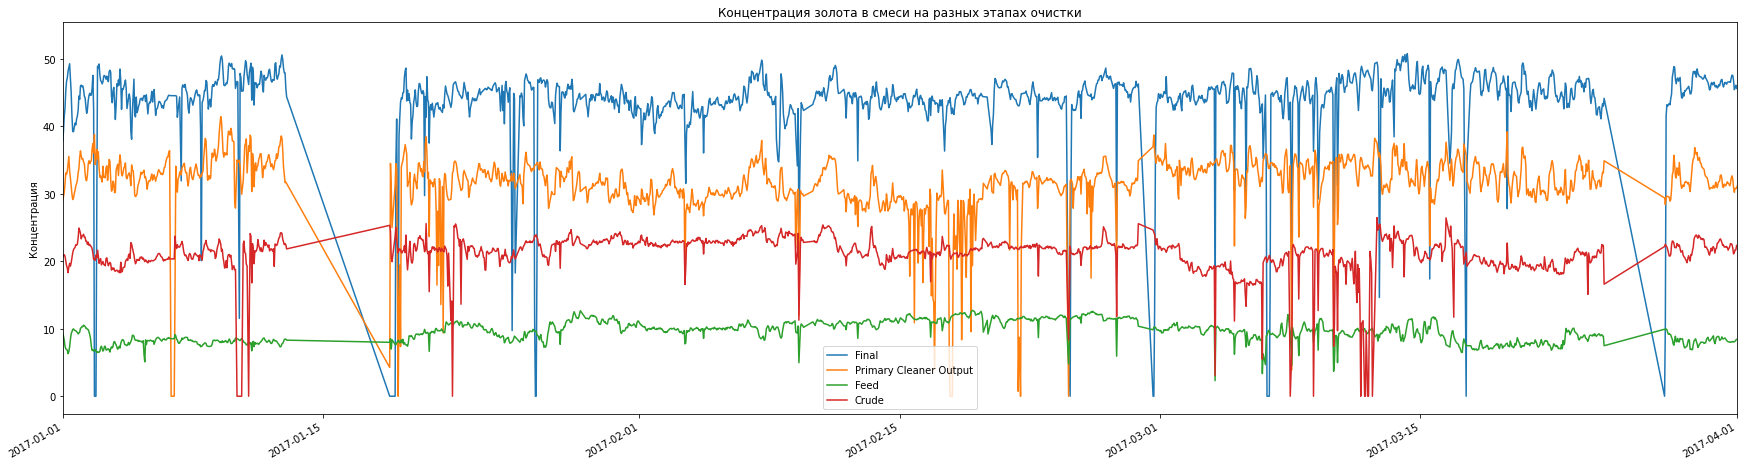

In [28]:
concentrations_au.plot.line(xlim=('2017-01-01 00:00:00', '2017-04-01 0:00:00'), figsize=(30, 8))
plt.title('Концентрация золота в смеси на разных этапах очистки')
plt.xlabel('')
plt.ylabel('Концентрация')
plt.legend(['Final', 'Primary Cleaner Output', 'Feed', 'Crude'])
plt.show()

Из графика видно, что как правило на каждом последующем этапе очистки концентрация золота в смеси растет.

### Серебро

In [29]:
concentrations_ag = concentrations.loc[:, concentrations.columns.str.endswith('ag')]

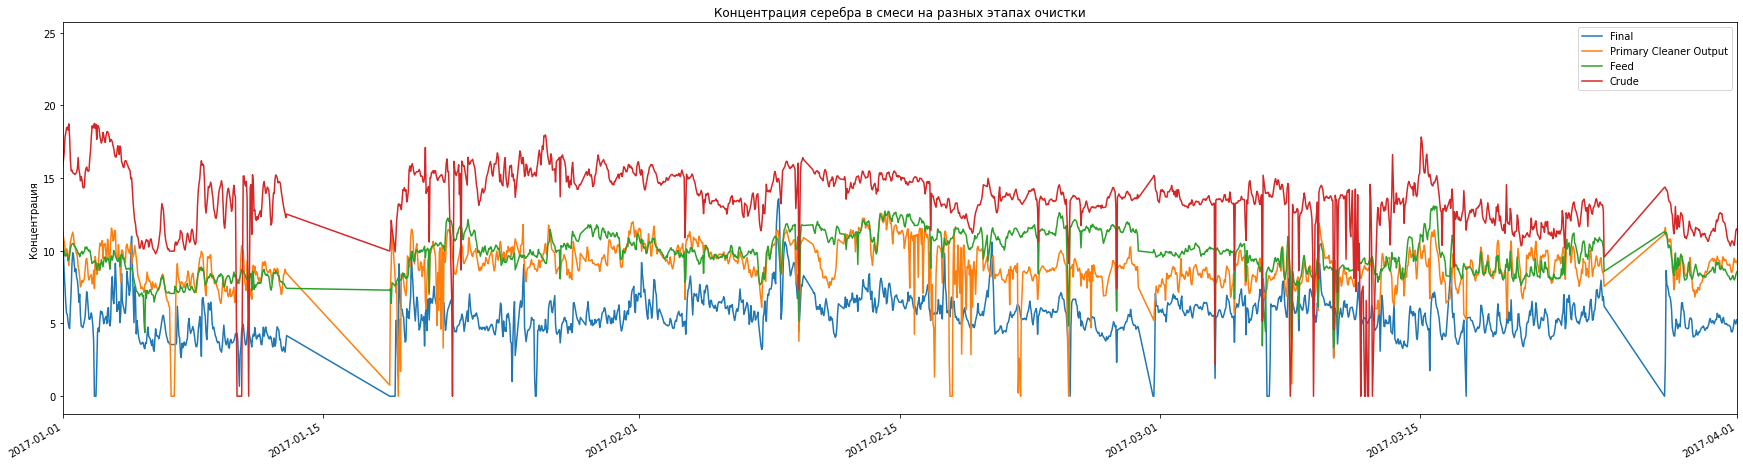

In [30]:
concentrations_ag.plot.line(xlim=('2017-01-01 00:00:00', '2017-04-01 0:00:00'), figsize=(30, 8))
plt.title('Концентрация серебра в смеси на разных этапах очистки')
plt.xlabel('')
plt.ylabel('Концентрация')
plt.legend(['Final', 'Primary Cleaner Output', 'Feed', 'Crude'])
plt.show()

Концентрация серебра на этапе флотации растет, а затем, при последующей очистке падает.

### Свинец

In [31]:
concentrations_pb = concentrations.loc[:, concentrations.columns.str.endswith('pb')]

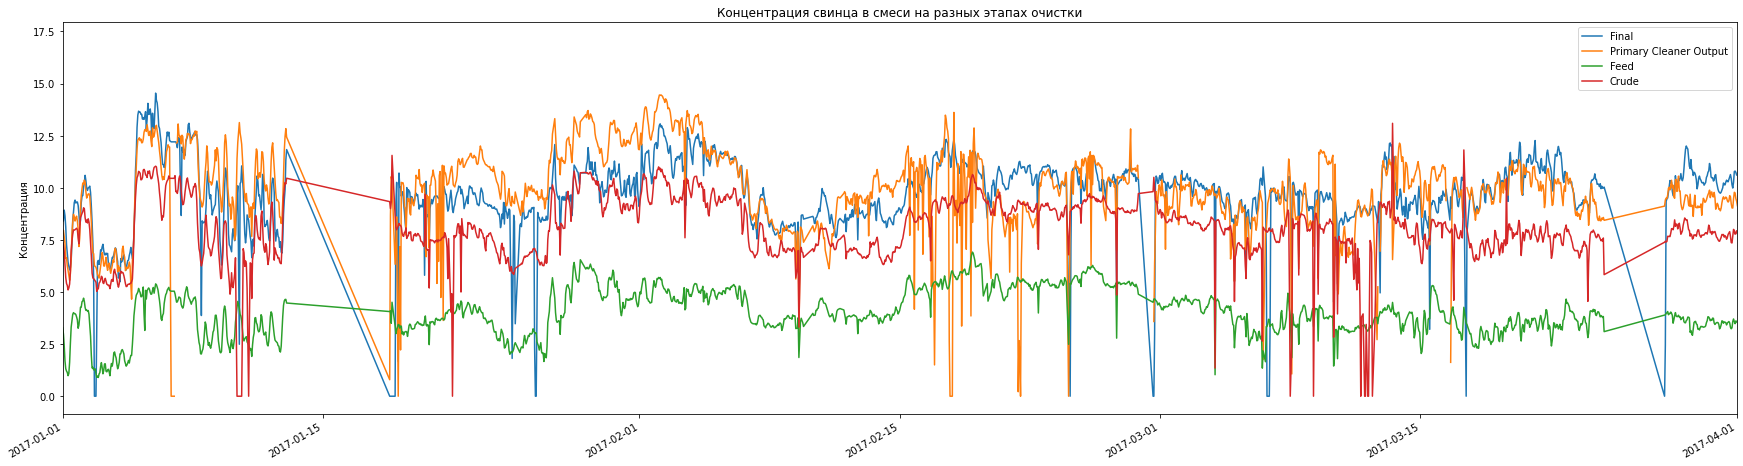

In [32]:
concentrations_pb.plot.line(xlim=('2017-01-01 00:00:00', '2017-04-01 0:00:00'), figsize=(30, 8))
plt.title('Концентрация свинца в смеси на разных этапах очистки')
plt.xlabel('')
plt.ylabel('Концентрация')
plt.legend(['Final', 'Primary Cleaner Output', 'Feed', 'Crude'])
plt.show()

Концентрация свинца растет после этапа флотации, затем ещё немного вырастает в процессе очистки.

### Вывод

Поскольку процесс обогащения направлен на повышение концентрации золота в смеси, то вполне логично, что его концентрация растет на всех этапах обогащения. Что касается других металлов: концентрация серебра в процессе очистки резко снижается; концентрация свинца свинца в процессе очистки повышается, видимо данный метод очистки не позволяет избавиться от примесей свинца.

Флотация же повышает концентрацию всех металлов в смеси.

## Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках.

Согласно заданию : *"Если распределения сильно отличаются друг от друга, оценка модели будет неправильной."*

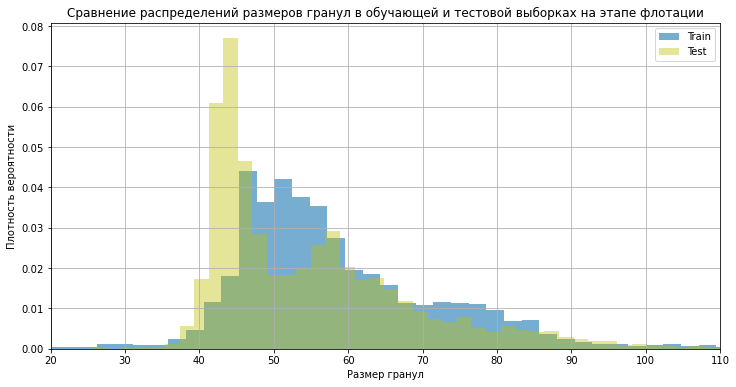

In [33]:
ax = data_train.plot(kind='hist', alpha=0.6, y='rougher.input.feed_size', label='Train', bins=200, density=True)
(
    data_test.plot(kind='hist', alpha=0.4, y='rougher.input.feed_size', label='Test', bins=200, density=True, xlim=(20, 110),
                            grid=True, title='Сравнение распределений размеров гранул в обучающей и тестовой выборках на этапе флотации', color='y', ax=ax, figsize=(12, 6))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Размер гранул')
plt.show()

На этапе флотации распределения размеров гранул несколько различаются. В тестовый выборке наблюдается ярко вырыженный пик на значениях от 42 до 44 у.е., которого не наблюдается в обучающей выборке. Но поскольку критерии *"сильных"* различий не заданы, и в целом распределения выглядят схоже, то ничто не мешает сказать, что это отличие не такое уж значительное. Выбора то все равно нет.

---

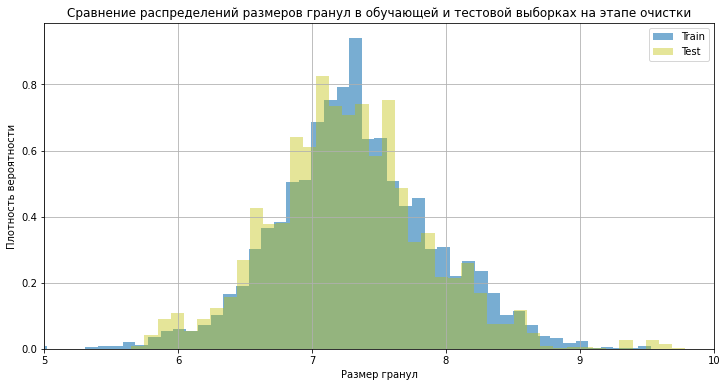

In [34]:
ax = data_train.plot(kind='hist', alpha=0.6, y='primary_cleaner.input.feed_size', label='Train', bins=100, density=True)
(
    data_test.plot(kind='hist', alpha=0.4, y='primary_cleaner.input.feed_size', label='Test', bins=100, density=True, xlim=(5, 10),
                            grid=True, title='Сравнение распределений размеров гранул в обучающей и тестовой выборках на этапе очистки', color='y', ax=ax, figsize=(12, 6))
)
plt.ylabel('Плотность вероятности')
plt.xlabel('Размер гранул')
plt.show()

В данном случае распределения действительно внешне очень близки.

## Исследование суммарных концентраций всех веществ на разных стадиях.

Посчитаем суммы концентраций металлов для сырья, чернового концентрата и финального концентрата.

In [35]:
concentraitions_feed = concentrations.loc[:, concentrations.columns.str.startswith('rougher.input.')].sum(axis=1)
concentrations_crude = concentrations.loc[:, concentrations.columns.str.startswith('rougher.output.')].sum(axis=1)
concentrations_final = concentrations.loc[:, concentrations.columns.str.startswith('final')].sum(axis=1)
concentrations_total = pd.DataFrame({'Feed' : concentraitions_feed, 'Crude' : concentrations_crude, 'Final' : concentrations_final})

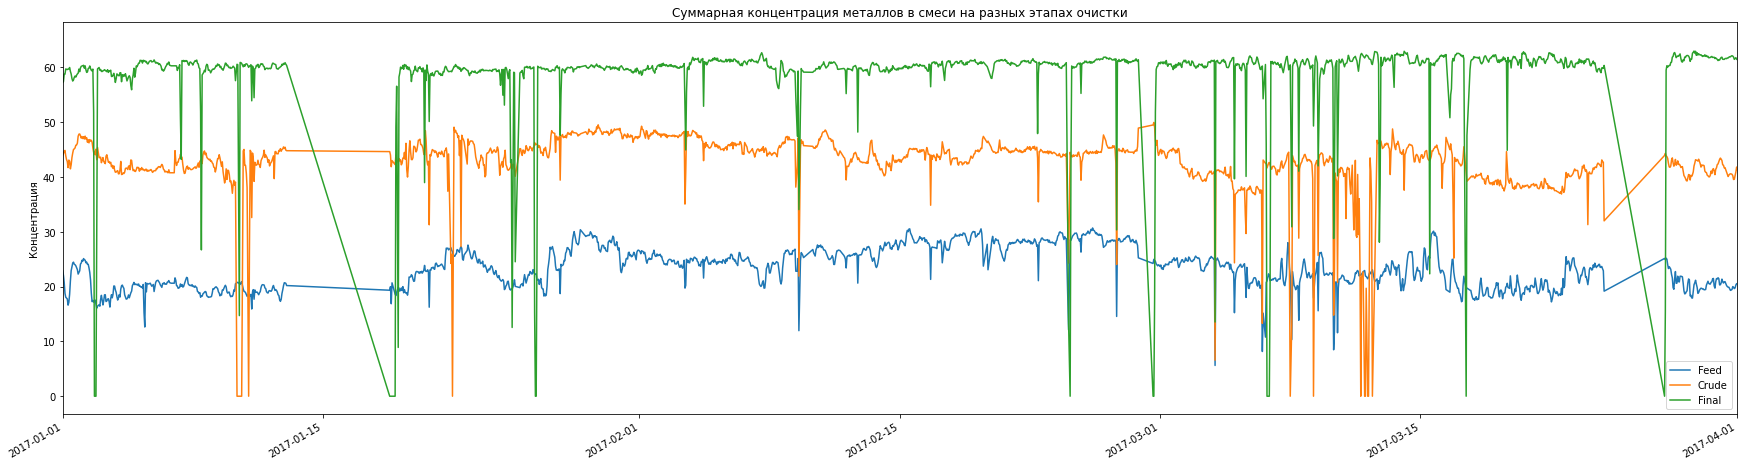

In [36]:
concentrations_total.plot.line(xlim=('2017-01-01 00:00:00', '2017-04-01 0:00:00'), figsize=(30, 8))
plt.title('Суммарная концентрация металлов в смеси на разных этапах очистки')
plt.xlabel('')
plt.ylabel('Концентрация')
plt.show()

По графику можно заметить множество аномальных значений для суммарной концентраций металлов как для чернового, так и для финального концентратов. Для лучшего качества модели такие аномальные значения лучше из обучающей выборки убрать.

Аномальные значения значения будут определяться следующим образом: Если суммарная концентрация металлов в финальном концентрате меньше чем в черновом, то это аномалия **или** если суммарная концентрация металлов в черновом концентрате меньше чем в сырье, то это аномалия.

In [37]:
concentration_anomaly = concentrations_total.query('Final < Crude or Crude < Feed')

In [38]:
print(data_train.shape)
data_train = data_train.loc[set(data_train.index) - set(concentration_anomaly.index), :].sort_index()
print(data_train.shape)

(14149, 54)
(13646, 54)


Таким образом из обучающей выборки было убрано 503 аномальных значения.

# Модели

Разделим обучающую и тестовую выборки на фичи и целевой признак. А также на выборки для предсказания эффективности обогащения чернового и финального концентратов.

In [39]:
X_train_rougher = data_train.loc[:, data_train.columns.str.startswith('rougher')].drop('rougher.output.recovery', axis=1)
X_test_rougher = data_test.loc[:, data_test.columns.str.startswith('rougher')].drop('rougher.output.recovery', axis=1)
y_train_rougher = data_train['rougher.output.recovery']
y_test_rougher = data_test['rougher.output.recovery']

X_train_final = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
X_test_final = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_final = data_train['final.output.recovery']
y_test_final = data_test['final.output.recovery']

Для линейной регрессии нормализуем данные в обучающей и тестовой выборках. На другие модели это не повлияет.

In [40]:
scaler = RobustScaler()
scaler.fit(X_train_rougher)
X_train_rougher = pd.DataFrame(scaler.transform(X_train_rougher), columns=X_train_rougher.columns, index=X_train_rougher.index)
X_test_rougher = pd.DataFrame(scaler.transform(X_test_rougher), columns=X_test_rougher.columns, index=X_test_rougher.index)

scaler.fit(X_train_final)
X_train_final = pd.DataFrame(scaler.transform(X_train_final), columns=X_train_final.columns, index=X_train_final.index)
X_test_final = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns, index=X_test_final.index)

## sMAPE

В силу специфики работы оценщика (scorer) в библиотеке sklearn показатель sMAPE будет оцениваться в отрицательных значениях. 

In [41]:
def sMAPE(y_true, y_predict):
    score = (abs(y_true - y_predict)/((abs(y_true) + abs(y_predict))/2)).mean()
    return score * 100

sMAPE_scorer = make_scorer(sMAPE, greater_is_better=False)

## Модель для предсказания эффективности обогащения чернового концентрата

In [42]:
rougher_models = {}
X_train = X_train_rougher
y_train = y_train_rougher

### Линейная регрессия

In [43]:
linear = LinearRegression()
linear.fit(X_train, y_train)
rougher_models['Linear'] = [linear, cross_val_score(estimator=linear, cv=5, X=X_train_rougher, y=y_train_rougher, scoring=sMAPE_scorer).mean()]

#### Решающее дерево

In [44]:
tree_cv = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=24),
    param_distributions={'max_depth' : range(1, 101), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=100,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
tree_cv.fit(X_train, y_train)
rougher_models['Tree'] = [tree_cv, tree_cv.best_score_]

#### Случайный лес

In [45]:
forest_cv = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=24, n_jobs=-1),
    param_distributions={'n_estimators' : range(1, 101), 'max_depth' : range(1, 51), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=20,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
forest_cv.fit(X_train, y_train)
rougher_models['Forest'] = [forest_cv, forest_cv.best_score_]

#### Градиентный бустинг

In [46]:
gradient_cv = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=24),
    param_distributions={'n_estimators' : range(5, 101), 'max_depth' : range(1, 51), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=10,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
gradient_cv.fit(X_train, y_train)
rougher_models['Gradient'] = [gradient_cv, gradient_cv.best_score_]

---

Общие результаты:

In [47]:
rougher_models

{'Linear': [LinearRegression(), -6.432187169098405],
 'Tree': [RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=24),
                     n_iter=100, n_jobs=-1,
                     param_distributions={'max_depth': range(1, 101),
                                          'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D83208B2B0>},
                     random_state=24,
                     scoring=make_scorer(sMAPE, greater_is_better=False)),
  -6.603084071308514],
 'Forest': [RandomizedSearchCV(cv=5,
                     estimator=RandomForestRegressor(n_jobs=-1, random_state=24),
                     n_iter=20, n_jobs=-1,
                     param_distributions={'max_depth': range(1, 51),
                                          'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D83216F4C0>,
                                          'n_estimators': range(1, 101)},
                     random_st

Из чего видно, что из данных моделей лучшей моделью для предсказания эффективности обогащения чернового концентрата по метрике sMAPE является GradientBoostingRegressor. Для дальнейшего предсказания по тестовой выборке будет использоваться именно эта модель.

#### Проверка на адекватность

При создании дамми модели заполняющей прогноз по среднему значению и пропуске её через аналогичную кросс-валидацию получается следующий рузультат.

In [48]:
cross_val_score(estimator=DummyRegressor(strategy='mean'), cv=5, X=X_train, y=y_train, scoring=sMAPE_scorer).mean()

-7.730714612644763

Что больше, чем показатель для любой из построенных ранее моделей. А значит все эти модели можно назвать адекватными.

## Модель для предсказания эффективности обогащения финального концентрата

In [49]:
final_models = {}
X_train = X_train_final
y_train = y_train_final

### Линейная регрессия

In [50]:
linear = LinearRegression()
linear.fit(X_train, y_train)
final_models['Linear'] = [linear, cross_val_score(estimator=linear, cv=5, X=X_train, y=y_train, scoring=sMAPE_scorer).mean()]

#### Решающее дерево

In [51]:
tree_cv = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=24),
    param_distributions={'max_depth' : range(1, 101), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=100,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
tree_cv.fit(X_train, y_train)
final_models['Tree'] = [tree_cv, tree_cv.best_score_]

#### Случайный лес

In [52]:
forest_cv = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=24, n_jobs=-1),
    param_distributions={'n_estimators' : range(1, 101), 'max_depth' : range(1, 51), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=20,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
forest_cv.fit(X_train, y_train)
final_models['Forest'] = [forest_cv, forest_cv.best_score_]

#### Градиентный бустинг

In [53]:
gradient_cv = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=24),
    param_distributions={'n_estimators' : range(5, 101), 'max_depth' : range(1, 51), 'min_samples_leaf' : stats.loguniform(2e-4, 1e-1)},
    n_iter=10,
    scoring=sMAPE_scorer,
    random_state=24,
    cv=5,
    n_jobs=-1
)
gradient_cv.fit(X_train, y_train)
final_models['Gradient'] = [gradient_cv, gradient_cv.best_score_]

---

Общие результаты:

In [54]:
final_models

{'Linear': [LinearRegression(), -10.993582192505416],
 'Tree': [RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=24),
                     n_iter=100, n_jobs=-1,
                     param_distributions={'max_depth': range(1, 101),
                                          'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D832CDBF70>},
                     random_state=24,
                     scoring=make_scorer(sMAPE, greater_is_better=False)),
  -9.211396149813364],
 'Forest': [RandomizedSearchCV(cv=5,
                     estimator=RandomForestRegressor(n_jobs=-1, random_state=24),
                     n_iter=20, n_jobs=-1,
                     param_distributions={'max_depth': range(1, 51),
                                          'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D83215B130>,
                                          'n_estimators': range(1, 101)},
                     random_s

Из чего видно, что из данных моделей лучшей моделью для предсказания эффективности обогащения финального концентрата по метрике sMAPE вновь является GradientBoostingRegressor. Для дальнейшего предсказания по тестовой выборке будет использоваться именно эта модель.

#### Проверка на адекватность

При создании дамми модели заполняющей прогноз по среднему значению и пропуске её через аналогичную кросс-валидацию получается следующий рузультат.

In [55]:
cross_val_score(estimator=DummyRegressor(strategy='mean'), cv=5, X=X_train, y=y_train, scoring=sMAPE_scorer).mean()

-10.331655395800713

Что больше, чем показатель для всех построенных ранее моделей, кроме линейной регрессии.

## Итоговая модель

In [56]:
rougher_predict = rougher_models['Gradient'][0].predict(X_test_rougher)
final_predict = final_models['Gradient'][0].predict(X_test_final)
rougher_sMAPE = sMAPE(y_test_rougher, rougher_predict)
final_sMAPE = sMAPE(y_test_final, final_predict)
total_sMAPE = 0.25 * rougher_sMAPE + 0.75 * final_sMAPE
print(f'''
sMAPE модели по оценке эффективности обогащения чернового концентрата = {rougher_sMAPE}
sMAPE модели по оценке эффективности обогащения финального концентрата = {final_sMAPE}
sMAPE итоговое = {total_sMAPE}
''')


sMAPE модели по оценке эффективности обогащения чернового концентрата = 7.337011797433345
sMAPE модели по оценке эффективности обогащения финального концентрата = 8.633531950632964
sMAPE итоговое = 8.309401912333058



Итоговая проверка на адекватность

In [57]:
rougher_dummy = DummyRegressor(strategy='mean').fit(X_train_rougher, y_train_rougher).predict(X_test_rougher)
final_dummy = DummyRegressor(strategy='mean').fit(X_train_final, y_train_final).predict(X_test_final)
rougher_sMAPE = sMAPE(y_test_rougher, rougher_dummy)
final_sMAPE = sMAPE(y_test_final, final_dummy)
total_sMAPE = 0.25 * rougher_sMAPE + 0.75 * final_sMAPE
print(f'''
\t\t***Дамми модель***
sMAPE модели по оценке эффективности обогащения чернового концентрата = {rougher_sMAPE}
sMAPE модели по оценке эффективности обогащения финального концентрата = {final_sMAPE}
sMAPE итоговое = {total_sMAPE}
\t\t***Дамми модель***
''')


		***Дамми модель***
sMAPE модели по оценке эффективности обогащения чернового концентрата = 8.926672599243773
sMAPE модели по оценке эффективности обогащения финального концентрата = 9.570852825713526
sMAPE итоговое = 9.409807769096087
		***Дамми модель***



Критерий sMAPE для дамми модели выше чем для модоли градиентного бустинга, что подтверждает адекватность модели.

# Вывод

Лучше всего с решением данной задачи справилось сочетание двух моделей градиентного бустинга. Обе модели успешно прошли проверку на адекватность как на обучающей выборке, так и на тестовой.

Полученный показатель sMAPE равен 8.31%.